In [1]:
from IPython.display import HTML
HTML('''
<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import math
import types

class Validator:
    def __init__(self, deposit, start_dynasty):
        # Used to determine the amount of wei the validator holds. To get the actual
        # amount of wei, multiply this by the deposit_scale_factor.
        self.deposit = deposit
        self.start_dynasty = start_dynasty
        self.end_dynasty = 100000000
        self.is_slashed = False
        self.total_deposits_at_logout = 0
        # The address which the validator's signatures must verify against
        self.addr = None
        self.withdrawal_addr = None


class Checkpoint:
    def __init__(self):
        # track size of scaled deposits for use in client fork choice
        self.cur_dyn_deposits = 0
        self.prev_dyn_deposits = 0
        # track total votes for each dynasty
        self.cur_dyn_votes = {0: 0}
        self.prev_dyn_votes = {0: 0}
        # Is a vote referencing the given epoch justified?
        self.is_justified = False
        # Is a vote referencing the given epoch finalized?
        self.is_finalized = False


class CasperContract:

    def __init__(self):

        # Map of validators and validator index
        self.validators = dict()

        # Next available validator index
        self.next_validator_index = 0

        # Current dynasty, it measures the number of finalized checkpoints
        # in the chain from root to the parent of current block
        self.dynasty = 0

        # Map of the change to total deposits for specific dynasty
        self.dynasty_wei_delta = {0: 0.0}

        # Total scaled deposits in the current dynasty
        self.total_curdyn_deposits = 0

        # Total scaled deposits in the previous dynasty
        self.total_prevdyn_deposits = 0

        # Mapping of dynasty to start epoch of that dynasty
        self.dynasty_start_epoch = {0: 0}

        # Mapping of epoch to what dynasty it is
        self.dynasty_in_epoch = {0: 0}

        self.checkpoints = {0: Checkpoint()}

        # Is the current expected hash justified
        self.main_hash_justified = False

        # Value used to calculate the per-epoch fee that validators should be charged
        self.deposit_scale_factor = {0: 1.0}

        self.last_nonvoter_rescale = 0.0
        self.last_voter_rescale = 0.0

        self.current_epoch = 0
        self.last_finalized_epoch = 0
        self.last_justified_epoch = 0

        # Reward for voting as fraction of deposit size
        self.reward_factor = 0.0

        # Expected source epoch for a vote
        self.expected_source_epoch = 0

        # Running total of deposits slashed
        self.total_slashed = {0: 0.0}

        # ***** Parameters *****

        # Length of an epoch in blocks
        self.EPOCH_LENGTH = 50

        # Withdrawal delay in blocks
        self.WITHDRAWAL_DELAY = 1.5e4

        # Logout delay in dynasties
        self.DYNASTY_LOGOUT_DELAY = 700

        self.BASE_INTEREST_FACTOR = 7e-3
        self.BASE_PENALTY_FACTOR = 2e-7
        self.MIN_DEPOSIT_SIZE = 1.5e21
        self.ETHER_IN_WEI = 1e18
        self.ONE_WEI = 1e-18

        self.DEFAULT_END_DYNASTY = 100000000

        # ****** Pre-defined Constants ******

        self.SLASH_FRACTION_MULTIPLIER = 3

    # Returns number of epochs since finalization.
    def esf(self):
        return self.current_epoch - self.last_finalized_epoch

    # Compute square root factor
    def sqrt_of_total_deposits(self):
        epoch = self.current_epoch
        ether_deposited_as_number = 1 + math.floor(
            max(self.total_prevdyn_deposits, self.total_curdyn_deposits) *
            self.deposit_scale_factor[epoch - 1] /
            self.ETHER_IN_WEI
        )

        sqrt = ether_deposited_as_number / 2.0
        for i in range(20):
            sqrt = (sqrt + (ether_deposited_as_number / sqrt)) / 2.0
        return sqrt

    def deposit_exists(self):
        return self.total_curdyn_deposits > 0.0 and self.total_prevdyn_deposits > 0.0

    def in_dynasty(self, validator_index, _dynasty):
        start_dynasty = self.validators[validator_index].start_dynasty
        end_dynasty = self.validators[validator_index].end_dynasty
        return (start_dynasty <= _dynasty) and (_dynasty < end_dynasty)

    # Increment dynasty when checkpoint is finalized.
    def increment_dynasty(self):
        epoch = self.current_epoch
        # Increment the dynasty if finalized

        if self.dynasty not in self.dynasty_wei_delta:
            self.dynasty_wei_delta[self.dynasty] = 0.0

        if epoch < 2 or self.checkpoints[epoch - 2].is_finalized:
            self.dynasty += 1
            self.total_prevdyn_deposits = self.total_curdyn_deposits

            if self.dynasty - 1 in self.dynasty_wei_delta:
                self.total_curdyn_deposits += self.dynasty_wei_delta[self.dynasty - 1]

            self.dynasty_start_epoch[self.dynasty] = epoch
        self.dynasty_in_epoch[epoch] = self.dynasty
        if self.main_hash_justified:
            self.expected_source_epoch = epoch - 1
        self.main_hash_justified = False

    def insta_finalize(self):
        epoch = self.current_epoch
        self.main_hash_justified = True

        if epoch > 0:
            self.checkpoints[epoch - 1].is_justified = True
            self.checkpoints[epoch - 1].is_finalized = True
            self.last_justified_epoch = epoch - 1
            self.last_finalized_epoch = epoch - 1
        else:
            self.checkpoints[0].is_finalized = True
            self.checkpoints[0].is_justified = True
            self.last_justified_epoch = 0
            self.last_finalized_epoch = 0

    # Returns the current collective reward factor, which rewards the dynasty for high-voting levels.
    def collective_reward(self):
        epoch = self.current_epoch
        live = self.esf() <= 2
        if not self.deposit_exists() or not live:
            return 0.0
        # Fraction that voted
        cur_vote_frac = 0
        if self.expected_source_epoch in self.checkpoints[epoch - 1].cur_dyn_votes:
            cur_vote_frac = self.checkpoints[epoch - 1].cur_dyn_votes[
                                self.expected_source_epoch] / self.total_curdyn_deposits
        prev_vote_frac = 0
        if self.expected_source_epoch in self.checkpoints[epoch - 1].prev_dyn_votes:
            prev_vote_frac = self.checkpoints[epoch - 1].prev_dyn_votes[
                                 self.expected_source_epoch] / self.total_prevdyn_deposits

        vote_frac = min(cur_vote_frac, prev_vote_frac)
        return vote_frac * self.reward_factor / 2.0

    # Reward the given validator & miner, and reflect this in total deposit figured
    def proc_reward(self, validator_index, reward):
        # Reward validator
        self.validators[validator_index].deposit += reward
        start_dynasty = self.validators[validator_index].start_dynasty
        end_dynasty = self.validators[validator_index].end_dynasty
        current_dynasty = self.dynasty
        past_dynasty = current_dynasty - 1
        if (start_dynasty <= current_dynasty) and (current_dynasty < end_dynasty):
            self.total_curdyn_deposits += reward
        if (start_dynasty <= past_dynasty) and (past_dynasty < end_dynasty):
            self.total_prevdyn_deposits += reward
        if end_dynasty < self.DEFAULT_END_DYNASTY:  # validator has submit `logout`
            self.dynasty_wei_delta[end_dynasty] -= reward

    # Removes a validator from the validator pool
    def delete_validator(self, validator_index):
        self.validators[validator_index] = None

    def total_curdyn_deposits_in_wei(self):
        return self.ONE_WEI * math.floor(self.total_curdyn_deposits * self.deposit_scale_factor[self.current_epoch])

    def total_prevdyn_deposits_in_wei(self):
        return self.ONE_WEI * math.floor(self.total_prevdyn_deposits * self.deposit_scale_factor[self.current_epoch])

    def deposit_size(self, validator_index):
        return self.ONE_WEI * math.floor(
            self.validators[validator_index].deposit * self.deposit_scale_factor[self.current_epoch])

    # Called at the start of any epoch
    def initialize_epoch(self, epoch):

        # must track the deposits related to the checkpoint _before_ updating current_epoch
        self.checkpoints[epoch] = Checkpoint()
        self.checkpoints[epoch].cur_dyn_deposits = self.total_curdyn_deposits_in_wei()
        self.checkpoints[epoch].prev_dyn_deposits = self.total_prevdyn_deposits_in_wei()

        self.current_epoch = epoch

        self.last_voter_rescale = 1.0 + self.collective_reward()
        self.last_nonvoter_rescale = self.last_voter_rescale / (1.0 + self.reward_factor)

        if epoch > 0:
            self.deposit_scale_factor[epoch] = self.deposit_scale_factor[epoch - 1] * self.last_nonvoter_rescale
            self.total_slashed[epoch] = self.total_slashed[epoch - 1]

        if self.deposit_exists():
            # Set the reward factor for the next epoch.
            adj_interest_base = self.BASE_INTEREST_FACTOR / self.sqrt_of_total_deposits()
            # self.reward_factor = adj_interest_base
            self.reward_factor = adj_interest_base + self.BASE_PENALTY_FACTOR * (self.esf() - 2)
            # ESF is only thing that is changing and reward_factor is being used above.
            assert self.reward_factor > 0.0
        else:
            # Before the first validator deposits, new epochs are finalized instantly.
            self.insta_finalize()
            self.reward_factor = 0

        # Increment the dynasty if finalized
        self.increment_dynasty()

    def deposit(self, value):
        assert value >= self.MIN_DEPOSIT_SIZE
        validator_index = self.next_validator_index
        start_dynasty = self.dynasty + 2
        scaled_deposit = value / self.deposit_scale_factor[self.current_epoch]
        self.validators[validator_index] = Validator(scaled_deposit, start_dynasty)
        self.next_validator_index += 1

        if start_dynasty not in self.dynasty_wei_delta:
            self.dynasty_wei_delta[start_dynasty] = 0

        self.dynasty_wei_delta[start_dynasty] += scaled_deposit
        return validator_index

    def logout(self, validator_index):

        # Check that we haven't already withdrawn
        end_dynasty = self.dynasty + self.DYNASTY_LOGOUT_DELAY
        assert self.validators[validator_index].end_dynasty > end_dynasty

        self.validators[validator_index].end_dynasty = end_dynasty
        self.validators[validator_index].total_deposits_at_logout = self.total_curdyn_deposits_in_wei()
        self.dynasty_wei_delta[end_dynasty] -= self.validators[validator_index].deposit

    def withdraw(self, validator_index):
        # Check that we can withdraw
        end_dynasty = self.validators[validator_index].end_dynasty
        assert self.dynasty > end_dynasty

        end_epoch = self.dynasty_start_epoch[end_dynasty + 1]
        withdrawal_epoch = end_epoch + self.WITHDRAWAL_DELAY
        assert self.current_epoch >= withdrawal_epoch

        # Withdraw
        if not self.validators[validator_index].is_slashed:
            withdraw_amount = self.ONE_WEI * self.validators[validator_index].deposit * self.deposit_scale_factor[
                end_epoch]
        else:
            # prevent a negative lookup in total_slashed
            if 2 * self.WITHDRAWAL_DELAY > withdrawal_epoch:
                base_epoch = 0
            else:
                base_epoch = withdrawal_epoch - 2 * self.WITHDRAWAL_DELAY

            recently_slashed = self.total_slashed[withdrawal_epoch] - self.total_slashed[base_epoch]
            fraction_to_slash = recently_slashed * self.SLASH_FRACTION_MULTIPLIER / self.validators[
                validator_index].total_deposits_at_logout

            # can't withdraw a negative amount
            fraction_to_withdraw = max((1.0 - fraction_to_slash), 0.0)

            deposit_size = self.ONE_WEI * math.floor(
                self.validators[validator_index].deposit * self.deposit_scale_factor[withdrawal_epoch])

            withdraw_amount = self.ONE_WEI * math.floor(deposit_size * fraction_to_withdraw)

        self.delete_validator(validator_index)
        return withdraw_amount

    # Process a vote message
    def vote(self, validator_index, source_epoch, target_epoch):

        # Record that this vote took place
        in_current_dynasty = self.in_dynasty(validator_index, self.dynasty)
        in_prev_dynasty = self.in_dynasty(validator_index, self.dynasty - 1)

        current_dynasty_votes = 0
        if source_epoch in self.checkpoints[target_epoch].cur_dyn_votes:
            current_dynasty_votes = self.checkpoints[target_epoch].cur_dyn_votes[source_epoch]

        previous_dynasty_votes = 0
        if source_epoch in self.checkpoints[target_epoch].prev_dyn_votes:
            previous_dynasty_votes = self.checkpoints[target_epoch].prev_dyn_votes[source_epoch]

        if in_current_dynasty:
            current_dynasty_votes += self.validators[validator_index].deposit
            self.checkpoints[target_epoch].cur_dyn_votes[source_epoch] = current_dynasty_votes
        if in_prev_dynasty:
            previous_dynasty_votes += self.validators[validator_index].deposit
            self.checkpoints[target_epoch].prev_dyn_votes[source_epoch] = previous_dynasty_votes

        # Process rewards.
        # Pay the reward if the vote was submitted in time and the vote is voting the correct data
        reward = 0
        if self.expected_source_epoch == source_epoch:
            reward = self.validators[validator_index].deposit * self.reward_factor
            self.proc_reward(validator_index, reward)

        # If enough votes with the same source_epoch and hash are made,
        # then the hash value is justified
        two_thirds_curdyn = current_dynasty_votes >= self.total_curdyn_deposits * 2.0 / 3.0
        two_thirds_prevdyn = previous_dynasty_votes >= self.total_prevdyn_deposits * 2.0 / 3.0
        enough_votes = two_thirds_curdyn and two_thirds_prevdyn

        if enough_votes and not self.checkpoints[target_epoch].is_justified:
            self.checkpoints[target_epoch].is_justified = True
            self.last_justified_epoch = target_epoch
            self.main_hash_justified = True

            # If two epochs are justified consecutively,
            # then the source_epoch finalized
            if target_epoch == source_epoch + 1:
                self.checkpoints[source_epoch].is_finalized = True
                self.last_finalized_epoch = source_epoch

        return reward

    # Cannot sign two votes for same target_epoch; no surround vote.
    def slash(self, validator_index):

        validator_deposit = self.deposit_size(validator_index)
        slashing_bounty = validator_deposit / 25
        self.total_slashed[self.current_epoch] += validator_deposit
        self.validators[validator_index].is_slashed = True

        # if validator not logged out yet, remove total from next dynasty
        # and forcibly logout next dynasty
        end_dynasty = self.validators[validator_index].end_dynasty
        if self.dynasty < end_dynasty:
            deposit = self.validators[validator_index].deposit
            self.dynasty_wei_delta[self.dynasty + 1] -= deposit
            self.validators[validator_index].end_dynasty = self.dynasty + 1

            # if validator was already staged for logout at end_dynasty,
            # ensure that we don't doubly remove from total
            if end_dynasty < self.DEFAULT_END_DYNASTY:
                self.dynasty_wei_delta[end_dynasty] += deposit
            # if no previously logged out, remember the total deposits at logout
            else:
                self.validators[validator_index].total_deposits_at_logout = self.total_curdyn_deposits_in_wei()

        return slashing_bounty

## Ethereum and Casper economics

### General definitions

Let's start giving some generic useful definitions used extensively.


#### Epoch
An epoch is a set of $\sigma$ subsequent blocks where $\sigma \in \mathbb{N}$ is called "epoch size".

Given the epoch size $\sigma$, and the set of all the existing blocks $\{b_{genesis}, b_1, ..., b_i\}$ we define the _n-th_ epoch as $ e_{n,\sigma}=\{b_{n\sigma}, b_{n\sigma+1}, ..., b_{n\sigma+\sigma-1}\} $.

the epoch size $\sigma$ is a static parameter initialized and never changed after the final definition of the protocol. For simplicity it will not be part of further difinitions.


#### Dynasty
A dynasty is a set of epochs that have been finalized together. This represents the dynasty of validators that is active for such epochs.  

If we define the set of all epochs $E=\{e_0, ..., e_n\}$ and the set of all dynasties $D=\{d_0, ..., d_n\}$ then we can define the _dynasty function_ $d:E\rightarrow D$ that maps any _epoch_ to its _dynasty_.

In optimal scenarios, where finalization happens every epoch, the function will constatly be in the form of $d(e_n)=d_n$.

#### Initial parameters
Casper has been defined with a set of initial parameters configured to achieve specific returns under specific conditions[1]:

- 200k ETH minimum total deposits for casper to be active
- ~4 months withdraw delay
- logout delay at 700 dynasties
- Base Interest Factor at $7\cdot10^{-3}$ to achieve a 5% yield with ~$10^{7}$ ETH in total deposits.
- Base Penalty Factor at $2\cdot10^{-7}$ so that if 50% of validator are offline then after ~3 weeks, the remaining pool will form a new majority.
- the minimum deposit is 1500 ETH creating ~900 validators considering ~$10^{7}$ ETH in total deposits.

#### Deposit scale factor
This function is used to scale the deposited amount of the validator when it enters the validator set, and then to scale any dimension related to deposits up till the total deposited amount at the moment of attempting a withdraw.

We introduce here the _deposit scale factor function_ defined in the following way:

$$
\begin{equation*}
    d_{sf}(t) =
        \begin{cases}
          1                                      & t = 0 \\
          d_{sf}(t-1) \frac{1+c_r(t)}{1+r_f(t)}  & \text{otherwise} \\
        \end{cases}
\end{equation*}
$$

where $r_f(t)$ is the _reward factor_ and $c_r(t)$ is the _collective reward_.

At the epoch $t$, given $d_v(d)$ the dynasty _votes_ for the dynasty d $d$ and $d_{td}(d)$ the dynasty _total deposits_ then we can define $c_r(t)$ the _collective reward function_ as:

$$ c_r(t)=min\Big(\frac{d_v(d(t-1))}{d_{td}(d(t))}, \frac{d_v(d(t-1)-1)}{d_{td}(d(t)-1)}\Big) \frac{r_f(t)}{2}$$

given the _reward factor_ $r_f(t)$ defined as:

$$
r_f(t)=\frac{7\cdot10^{-3}}{\sqrt{{\frac{1 + max\big(d_{td}(d(t)),d_{td}(d(t-1))\big) d_{sf}(t-1)}{10^{18}}}}}+2\cdot10^{-7}e_{sf}(t)=\frac{7\cdot10^{-12}}{\sqrt{1 + max\big(d_{td}(d(t)),d_{td}(d(t-1))\big) d_{sf}(t-1)}}+2\cdot10^{-7}e_{sf}(t)
$$


Specifically $7\cdot10^{-3}$ is the _base interest factor_ and $2\cdot10^{-7}$ is the _base penalty factor_, those are a protocol initial parameters. $10^{18}$ represents a scaling factor equivalent to the amount of _wei_s per _ether_. The function $e_{sf}(t)$ measures the distance in epocs between the epoch $t$ and the last finalized epoch.

We now assume that finalization will be accomplished every epoch and the deposits will not vary in time. In this scenario if we set the total constant deposits in the system to $10^{7}$ ETH (casper's ideal scenario) we can observe the bahvior of $d_{sf}(t)$ as it linearly decreases with a yield of ~5%/yr:

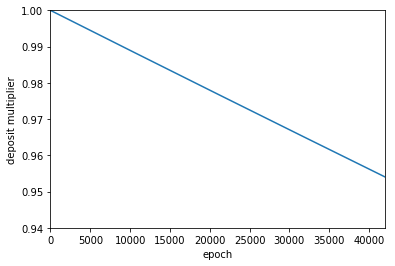

In [3]:
BASE_INTEREST_FACTOR = 7e-3
time_span = int(1 * (365 * 24 * 3600 / (15 * 50)))  # 1 year of epochs
deposits = 10e24
dsf = [1.0]

def reward_factor(dyn):
    global deposits
    sqrt_dep = math.sqrt(1 + (deposits * dsf[dyn] / 1e18))
    return BASE_INTEREST_FACTOR / sqrt_dep

def collective_reward(dyn):
    return reward_factor(dyn) / 2.0

for dyn in range(0, time_span):
    new_dsf = dsf[dyn] * (1 + collective_reward(dyn)) / (1 + reward_factor(dyn))
    dsf.append(new_dsf)

plt.plot(range(len(dsf)), dsf)
plt.xlabel('epoch')
plt.ylabel('deposit scale factor')
plt.axis([0, len(dsf), 0.94, 1.0])
plt.show()

#### Vote reward

In the previous paragraph we've shown that a validator would actually lose ETH over time just for being part of the system even in perfect conditions; to counterbalance this casper introduces a reward for succesful votes.

Every time a validator successfully gets a vote included in a block he will receive a reward equal to its current deposit multiplied by $r_f$.
This reward will compound with the deposit eventually making up for the loss and actually granting a positive yield.
Given the current validator deposit $v_d(t)$ then we define the vote reward $v_r(t)$ as:

$$
v_r(t)=v_d(t)\cdot r_f(t)
$$

We then include this reward in the previous model and observe that the validators' return over time is linearly increasing in optimal finalization scenarios at a rate of ~4.6%/yr respective of their deposit.

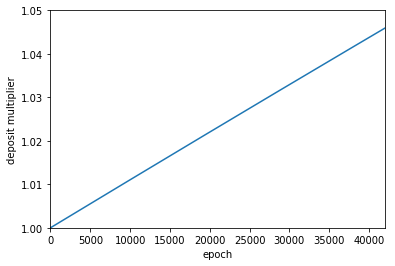

Compound yield per month:
1:	0.39%
2:	0.77%
3:	1.16%
4:	1.55%
5:	1.93%
6:	2.31%
7:	2.70%
8:	3.08%
9:	3.46%
10:	3.84%
11:	4.22%
12:	4.60%



In [4]:
tot_deposits = [10e24]
deposits = tot_deposits[0]
yield_ = []
 
s = "Compound yield per month:\n"
for epoch in range(0, time_span):
    deposits *= (1 + reward_factor(epoch))
    tot_deposits.append(deposits*dsf[epoch])
    yield_.append(tot_deposits[epoch]/tot_deposits[0])
    if epoch%3504 == 3503:
        s += f'{(int)(epoch/3503)}:\t{"{:.2%}".format(yield_[epoch]-1)}\n'
    
plt.plot(range(len(yield_)), yield_)
plt.xlabel('epoch')
plt.ylabel('deposit scale factor')
plt.axis([0, len(yield_), 1.0, 1.05])

plt.show()
print(s)

In optimal finalization scenarios the expected yield is function of the total amount of deposits in the system. If we consider deposits to remain constant after a certain time $T$ we can describe the expected _deposit scale factor_ as:

$$
v_d(t)= v_d(t-1)\cdot\big(d_{sf}(t) + r_f(t)\big)
$$

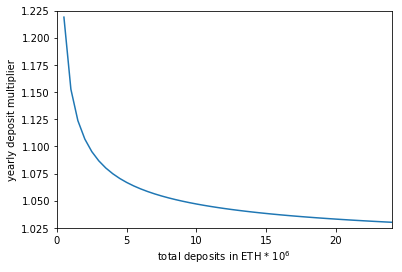

In [5]:
def generate_roi(time_span, deposit):
    c = CasperContract()

    c.initialize_epoch(0)
    c.deposit(deposit)
    roi = []

    for i in range(1, time_span):
        c.initialize_epoch(i)
        c.vote(0, i - 1, i)
        roi.append(c.deposit_size(0) / deposit * 1e18)

    return roi

time_span = int(1 * (365 * 24 * 3600 / (15 * 50)))  # 1 year of epochs

d = list()
for deposit in range(1, 50, 1):
    roi = generate_roi(time_span, deposit * 0.5e24)
    d.append(roi[len(roi)-1])

plt.plot([x * 0.5 for x in range(1, len(d)+1)], d)
plt.xticks(np.arange(0, len(d)*0.5, 5))
plt.xlabel('total deposits in ETH * $10^6$')
plt.ylabel('deposit scale factor')
plt.axis([0, 24, 1.025, 1.225])
plt.show()

#### Suboptimal finalization

In case more than a third of the validators will go offline (and stay so) the _base penalty factor_ will kick in causing the rapid shrinking of non-voting validators (how fast depends on how much stake is not voting) and eventually this will lead to a new super-majority of voters being formed so that finalization can continue.

For example if we consider the scenario where 50% of the total deposits is own by non-voting validators we will obtain the following:

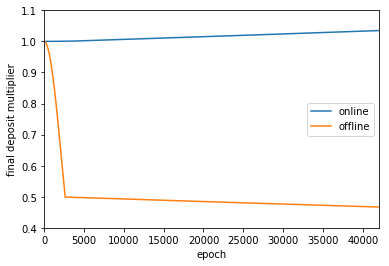

voters yearly yield: 3.49%
non-voters yearly yield: -53.31%


In [6]:
c = CasperContract()

c.initialize_epoch(0)
c.deposit(5e24)
c.deposit(5e24)

roi_online = []
roi_offline = []

for i in range(1, time_span):
    c.initialize_epoch(i)
    if i < 4:
        c.vote(0, i-1, i)
    elif i < 2630:
        c.vote(0, 3, i)
    else:
        c.vote(0, i-1, i)
    
    roi_online.append(c.deposit_size(0) / 5e24 * 1e18)
    roi_offline.append(c.deposit_size(1) / 5e24 * 1e18)
    
plt.plot(range(len(roi_online)), roi_online, label="online")
plt.plot(range(len(roi_offline)), roi_offline, label="offline")
plt.xlabel('epoch')
plt.ylabel('deposit scale factor')
plt.legend(loc='center right')
plt.axis([0, len(roi_online), 0.4, 1.1])
plt.show()

print(f'voters yearly yield: {"{:.2%}".format(roi_online[len(roi_online)-1]-1)}')
print(f'non-voters yearly yield: {"{:.2%}".format(roi_offline[len(roi_offline)-1]-1)}')

In case instead that validators are not relyable in voting on time or correctly we are going to witness a slight lower reward rate for the whole network and a decrease in their reward whenever they are unable to vote more than ~%60 of the time.

In the case where a super-majority of the validators votes, but 30% of them is constantly offline, we can see how the yearly yield shrinks for voting and non-voting nodes.

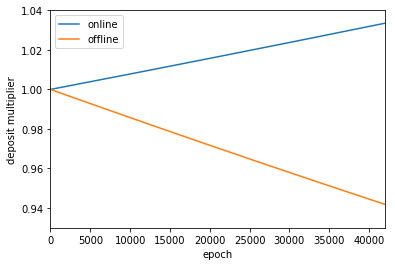

voters yearly yield: 3.35%
non-voters yearly yield: -5.82%


In [155]:
c = CasperContract()

c.initialize_epoch(0)
c.deposit(7e24)
c.deposit(3e24)

roi_online = []
roi_offline = []

for i in range(1, time_span):
    c.initialize_epoch(i)
    c.vote(0, i - 1, i)
    roi_online.append(c.deposit_size(0) / 7e24 * 1e18)
    roi_offline.append(c.deposit_size(1) / 3e24 * 1e18)
    
plt.plot(range(len(roi_online)), roi_online, label="online")
plt.plot(range(len(roi_offline)), roi_offline, label="offline")
plt.xlabel('epoch')
plt.ylabel('deposit multiplier')
plt.legend(loc='upper left')
plt.axis([0, len(roi_online), 0.93, 1.04])
plt.show()

print(f'voters yearly yield: {"{:.2%}".format(roi_online[len(roi_online)-1]-1)}')
print(f'non-voters yearly yield: {"{:.2%}".format(roi_offline[len(roi_offline)-1]-1)}')

## Unit-e token inflation

In this section we ananlyze the model given for the Unit-e token inflation a we try to put in prospective with the economic model given from the casper model.

The target total supply of Unit-e is $e$ billion units, where $e$ is the matematical constant that can be characterized by the infinite series:

$$
e = \frac{1}{2}\sum_{k=0}^{\infty}\frac{k+1}{k!}
$$

We want to complete the token issuance in 50 years and to do so we plan to adjust the block reward exaclty every 1,971,000 blocks, this interval is called _period_ and corresponds to 1 year if we account for block time to be of 16 seconds. We define then the _block reward function_ $B_r(p)$ for the _period_ $p$ as:

$$
    B_r(p) = \frac{1}{2}\frac{p+1}{p!}
$$

As per [3] we decided to have a high initial token supply in order to prevent strong inequitabilty especially caused by coumpounding effects in early joiners. To achieve so the genesis block will contain $1.5\cdot10^9$ units, that comes from the formula above summing the results for $p=0$ and $p=1$.

In practice we slightly adjust those values to bring the total supply after 50 year very close to 271828182845904523 satoshis.

$$ B_r(2) = 37.5 \quad \text(units) $$
$$ B_r(3) = 17 \quad \text(units) $$
$$ B_r(4) = 5.5 \quad \text(units) $$
$$ B_r(5) = 1.5 \quad \text(units) $$
$$ B_r(6) = 0.31 \quad \text(units) $$

For the sake of this work we will also refer as _inflation_ the depreciation of the token caused solely by the dilution effect of the growing supply.


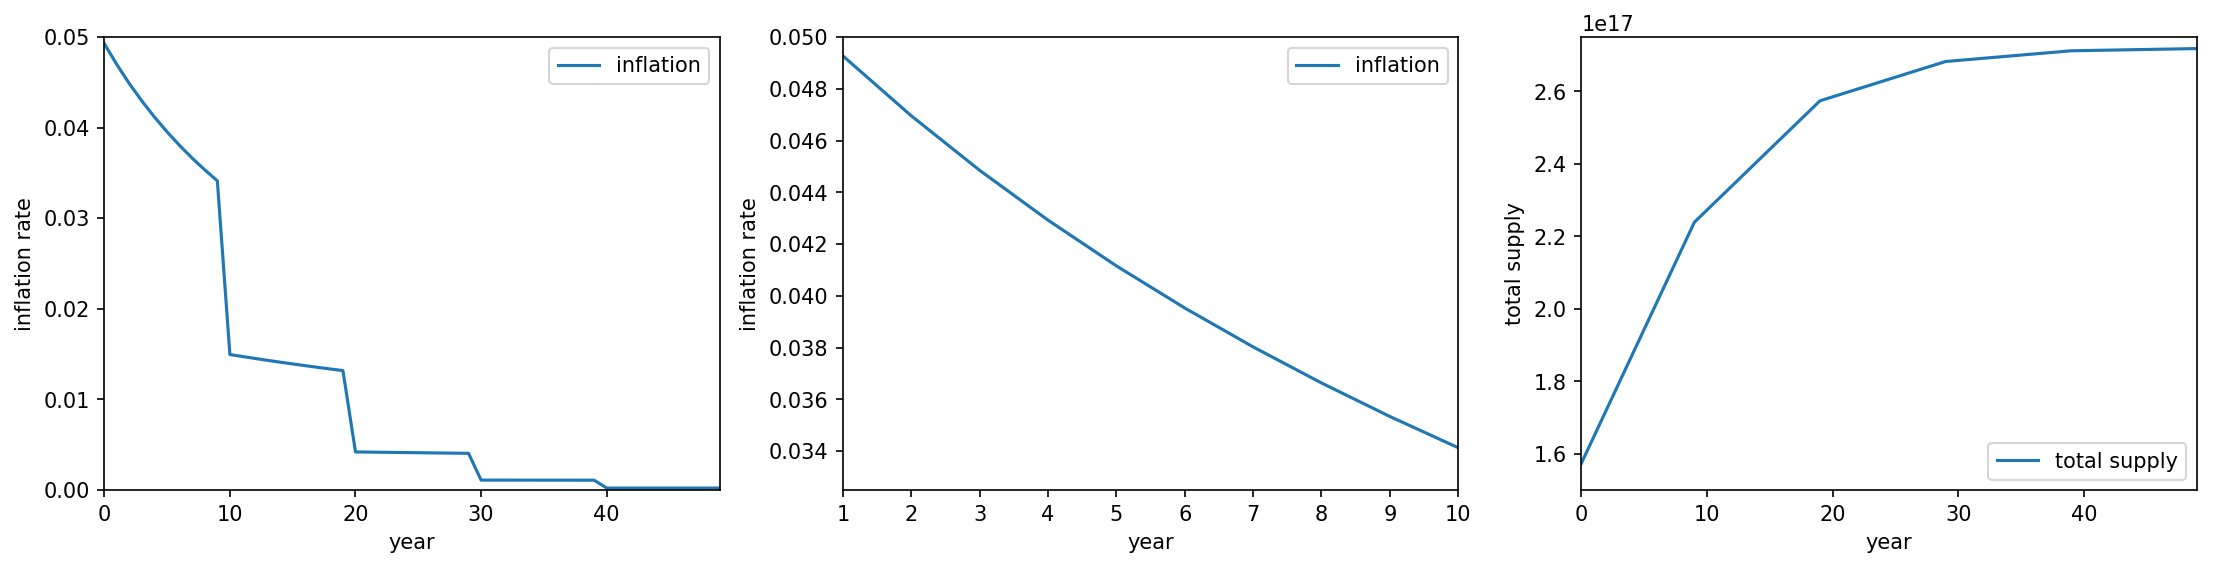

The perfect reward schedule is [3750000000.0, 1666666666.6666665, 520833333.3333334, 125000000.0, 24305555.555555556]
The adjusted reward schedule is [3750000000, 1700000000, 550000000, 150000000, 31000000]
The perfect total supply is: 2.718281828459045e+17 satoshis
The adjusted total supply is: 2.7182751e+17 satoshis
The difference is: 7e+03 units


In [156]:
UNIT = 100_000_000
init_blk_rw = 50 * UNIT
initial_supply = 1_500_000_000 * UNIT
block_yr = 60*60*24*365/16
blk_rw_yr = [3750000000, 1700000000, 550000000, 150000000, 31000000]

def perf_blk_rw(yr):
    return 0.5 * ((yr+2)/math.factorial(yr+1)) * init_blk_rw

def adj_blk_rw(yr):
    return blk_rw_yr[yr-1]

def tot_supply(yr):
    supply = initial_supply
    for i in range(0, yr):
        supply += adj_blk_rw(((int)(i/10))+1) * block_yr
    return supply

def inflation(yr):
    return (tot_supply(yr)/tot_supply(yr-1)) - 1

inf = []
for i in range(1, 51):
    yr = i*block_yr
    inf.append(inflation(i))

plt.figure(figsize=(18, 4), dpi=150, facecolor='w', edgecolor='k')

plt.subplot(1,3,1)
plt.plot(range(len(inf)), inf, label="inflation")
plt.xlabel('year')
plt.ylabel('inflation rate')
plt.legend(loc='upper right')
plt.axis([0, len(inf)-1, 0, 0.05])

plt.subplot(1,3,2)
plt.plot(range(10), inf[0:10], label="inflation")
plt.xlabel('year')
plt.ylabel('inflation rate')
plt.legend(loc='upper right')
plt.axis([1, 9, 0.0325, 0.05])
plt.xticks(np.arange(10), (range(1,11)))

supply = []
for i in range(1, 51):
    supply.append(tot_supply(i))
    
plt.subplot(1,3,3)
plt.plot(range(len(supply)), supply, label="total supply")
plt.xlabel('year')
plt.ylabel('total supply')
plt.legend(loc='lower right')
plt.axis([0, len(supply)-1, 1.5e17, 2.75e17])

plt.show()

expected_supply = 2.71828182845904523e17
actual_supply = tot_supply(50)
perfect_rewards = [perf_blk_rw(1),perf_blk_rw(2),perf_blk_rw(3),perf_blk_rw(4),perf_blk_rw(5)]
print(f'The perfect reward schedule is {perfect_rewards}')
print(f'The adjusted reward schedule is {blk_rw_yr}')
print(f'The perfect total supply is: {expected_supply} satoshis')
print(f'The adjusted total supply is: {actual_supply} satoshis')
print(f'The difference is: {"{:.0e}".format((expected_supply - actual_supply)/1e8)} units')

## Unit-e validators economic model

In this section we define the Unit-e initial parameters concerning validators, describe the expected yield and make a simple cost analysis for running such nodes for different market caps.

#### Target deposits
In order to keep the network secure we need a minimum amount of deposits from validators. Risking to be slashed for the amount of $1/3$ of this should be enough of a deterrent to prevent double finalization attempts.
The target total deposit $T_d$ we try to estimate is a value tighly coupled to the market evaluation of the coin, hence we can only speculate and try to set it to a reasonable amount.

Let's assume a range of evaluation for a single unit from 0.02 \\$ to 1 \\$ and $T_d = 270\cdot10^6$ units then the following table emerges:


In [157]:
target_total_deposit = 270_000_000 * UNIT
print(f'market value \t cost of 33% attack')
print(f'0.02$ \t\t {"{:,}".format(target_total_deposit * 0.02 / 3 / UNIT)}$')
print(f'0.05$ \t\t {"{:,}".format(target_total_deposit * 0.05 / 3 / UNIT)}$')
print(f'0.1$ \t\t {"{:,}".format(target_total_deposit * 0.1 / 3 / UNIT)}$')
print(f'0.5$ \t\t {"{:,}".format(target_total_deposit * 0.5 / 3 / UNIT)}$')
print(f'1.0$ \t\t {"{:,}".format(target_total_deposit * 1.0 / 3 / UNIT)}$')
print()
print(f'This will account for the {"{:.2%}".format(target_total_deposit/initial_supply)} of the inital supply or the {"{:.2%}".format(target_total_deposit/actual_supply)} of the final total supply')

market value 	 cost of 33% attack
0.02$ 		 1,800,000.0$
0.05$ 		 4,500,000.0$
0.1$ 		 9,000,000.0$
0.5$ 		 45,000,000.0$
1.0$ 		 90,000,000.0$

This will account for the 18.00% of the inital supply or the 9.93% of the final total supply


#### Yield function
As we will see again later in the section dedicated to the proposers economics, we decide to split evenly the block reward between proposers and validators. Furthermore not all the block reward is meant to be credited immediately for either role, more specifically for validators, it will accumulate in a fund at a faster peace than it could be withdrawn, so that we can guarantee some constant yearly yield that is not tightly coupled to the inflation. This helps preventing the case where after the first decade or so, the fast shrinking of the block reward will make the validator role extremely unfavorable due to the exercise costs unless there is a very consistent appreciation of the coin in value that at the moment we cannot forsee.

One way to guarantee a fair yield with an aggressive and fast decreasing inflation is to provide a fixed percentage of returns on top of the current inflation. We can calculate the value that let us pay out the complete validator fund in 50 years. After this period no more tokens will be issued and we will fallback to the fees to pay both validators and proposers.

Given $I_{nf}(i)$ the inflation for year $i$ we define $Y_{yr}$ the yearly yield over inflation as the one that satisfies the following equation:
$$
    \sum_{i=0}^{49} \frac{B_r(\lfloor \frac{i}{10} \rfloor + 2)}{2}\cdot1971000 - T_d(I_{nf}(i)+Y_{yr}) = 0
$$

If we replace the variables with the parameters already defined we find that $Y_{yr}$ is about 3.3%.

The leftover in the validator fund after 50 years is about 7e-01 units


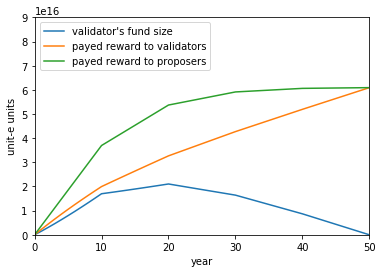

In [51]:
yr_yield_over_infl = 0.0330443687
def yield_yr(yr):
    return inflation(yr) + yr_yield_over_infl

validators_fund = [0]
val_rew_payed = [0]
prop_rew_payed = [0]
for i in range(1, 51):
    yr_add_fund = adj_blk_rw(((int)((i-1)/10))+1)*0.5*block_yr
    validators_fund.append(validators_fund[i-1] + yr_add_fund - (target_total_deposit*yield_yr(i)))
    val_rew_payed.append(val_rew_payed[i-1] + target_total_deposit*yield_yr(i))
    prop_rew_payed.append(prop_rew_payed[i-1] + (tot_supply(i)-tot_supply(i-1))*0.5)
    
plt.plot(range(len(validators_fund)), validators_fund, label="validator's fund size")
plt.plot(range(len(val_rew_payed)), val_rew_payed, label="payed reward to validators")
plt.plot(range(len(prop_rew_payed)), prop_rew_payed, label="payed reward to proposers")
plt.xlabel('year')
plt.ylabel('units')
plt.legend(loc='upper left')
plt.axis([0, 50, 0, 9e16])
plt.show()

print(f'The leftover in the validator fund after 50 years is about {"{:.0e}".format(validators_fund[len(validators_fund)-1]/1e8)} units')
                                                                                              

Any leftover due to imperfect finalization and voting will cause the exceeding tokens to be burned immediately, so that after the total supply has been issued there are no more tokens in the validator fund.

From the figure above is evident that in the first 20 years we accumulate tokens in the validator fund at a faster peace than what we can pay out and in the last 30 viceversa. This behavior causes a change in the real inflation that changes as shown below:

[1, 50, 0, 0.05]

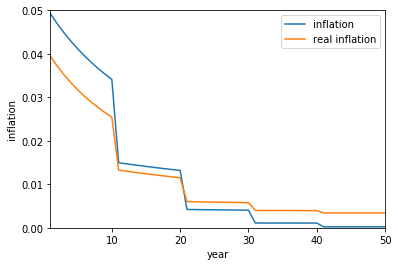

In [158]:
# Effective inflation considering validator's fund
actual_inf = []
for i in range(1, 51):
    actual_inf.append(inflation(i) - ((validators_fund[i]-validators_fund[i-1])/tot_supply(i-1)))
    
plt.plot(range(1,51), inf, label="inflation")
plt.plot(range(1,51), actual_inf, label="real inflation")
plt.xlabel('year')
plt.ylabel('inflation')
plt.legend(loc='upper right')
plt.axis([1, 50, 0, 0.05])

If we then compare the total yield, the inflation and the yield over the inflation we want to achieve:

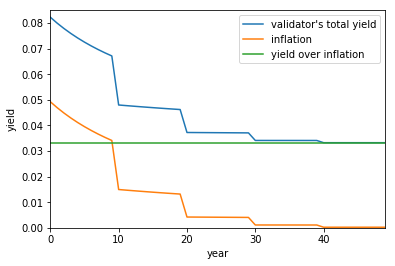

In [202]:
total_yield_yr = []
yield_over_infl = []
compound_yield = [1]

for i in range(1, 51):
    total_yield_yr.append(yield_yr(i))
    yield_over_infl.append(yield_yr(i)-inf[i-1])
    compound_yield.append(compound_yield[i-1]*(1+yield_yr(i)))
    
plt.plot(range(len(total_yield_yr)), total_yield_yr, label="validator's total yield")
plt.plot(range(len(inf)), inf, label="inflation")
plt.plot(range(len(yield_over_infl)), yield_over_infl, label="yield over inflation")
plt.xlabel('year')
plt.ylabel('yield')
plt.legend(loc='upper right')
plt.axis([0, 49, 0, 0.085])
plt.show()

Considering the above set yield, if we want to project the _deposit scale factor_ similarly to what we did for casper, in case of optimal finalization we would obtain:

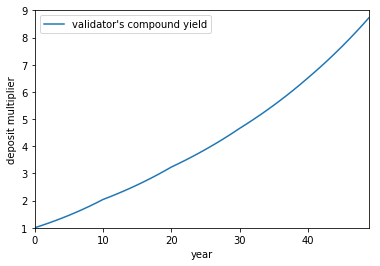

year 	 yield
1 	 8.23%
11 	 4.80%
21 	 3.73%
31 	 3.41%
41 	 3.33%


In [160]:
plt.plot(range(len(compound_yield)), compound_yield, label="validator's compound yield")
plt.xlabel('year')
plt.ylabel('deposit scale factor')
plt.legend(loc='upper left')
plt.axis([0, 49, 1, 9])
plt.show()

print(f'year \t yield')
for i in range(5):
    print(f'{i*10+1} \t {"{:.2%}".format(total_yield_yr[i*10])}')

We just defined $Y_{yr}$ in the case where the validators total deposits are $d_{td} = T_d$. Since Unit-e supply is finite we have to adjust this value in case that $d_{td}$ deviates from the target. The easiest and most straightforward way to do it is to define $Y_{yr}(d_{td})$ as a function of the total deposit so that the yield increases or decreses proportionally as $d_{td}$ changes.
$$
    Y_{yr}(epoch) = \frac{T_d (I_{nf}(epoch) + Y_{yr})}{d_{td}(epoch)} - I_{nf}(epoch)
$$

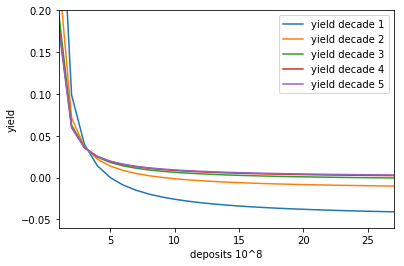

the following table emerges for the yield over the inflation in the first year
fraction of TD 	 yield
0.1 		 77.39%
0.3 		 22.51%
0.5 		 11.54%
1 		 3.30%
1.2 		 1.93%
1.5 		 0.56%
2 		 -0.81%
5 		 -3.28%


In [281]:
y = [[0],[0],[0],[0],[0]]

def yield_yr_dep(yr, tot_deposit):
    return yield_yr(yr) * (target_total_deposit/tot_deposit) - inflation(yr)

for i in np.arange(50000000 * UNIT, actual_supply, 100_000_000 * UNIT):
    for j in range(0,5):
        y[j].append(yield_yr_dep(j*10+1, i))
    
for j in range(0,5):
    plt.plot(range(len(y[j])), y[j], label=f'yield decade {j+1}')
    
plt.xlabel('deposits 10^8')
plt.ylabel('yield')
plt.legend(loc='upper right')
plt.axis([1, len(y[0])-1, -0.06, 0.2])
plt.show()

print("the following table emerges for the yield over the inflation in the first year")
print(f'fraction of TD \t yield')
for i in [0.1, 0.3, 0.5, 1, 1.2, 1.5, 2, 5]:
    print(f'{i} \t\t {"{:.2%}".format(yield_yr_dep(1, i * target_total_deposit))}')


We set now the inital parameters of the Unit-e equivalent of the casper contract.

In [14]:
class UnitEContract(CasperContract):
    
    def __init__(self):
        CasperContract.__init__(self)
        self.BASE_INTEREST_FACTOR = 1.67665e-6
        self.BASE_PENALTY_FACTOR = 2e-7
        self.MIN_DEPOSIT_SIZE = 0
        self.ETHER_IN_WEI = 1e8
        self.ONE_WEI = 1e-8

    def sqrt_of_total_deposits(self):
        epoch = self.current_epoch
        units_deposited_as_number = 1 + math.floor(
            max(self.total_prevdyn_deposits, self.total_curdyn_deposits) *
            self.deposit_scale_factor[epoch - 1] /
            self.ETHER_IN_WEI
        )
        return units_deposited_as_number / (target_total_deposit / 1e8)


In case of suboptimal finalization, Unit-e behaves similarly to casper harshly punishing offline nodes, and mildly punishing all the others.

In case of constant optimal finalization we obtain:

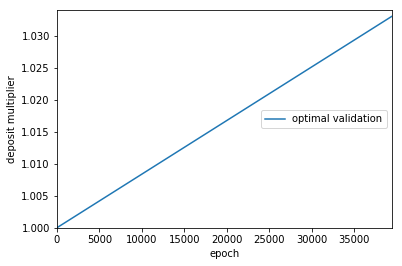

optimal finalization yearly yield: 3.304417%


In [15]:
c = UnitEContract()

c.initialize_epoch(0)
c.deposit(target_total_deposit)

optimal_yield = []

for i in range(0, (int)(block_yr/50)):
    c.initialize_epoch(i)
    c.vote(0, i-1, i)
    optimal_yield.append(c.deposit_size(0) / target_total_deposit * 1e8)
    
plt.plot(range(len(optimal_yield)), optimal_yield, label="optimal validation")
plt.xlabel('epoch')
plt.ylabel('deposit multiplier')
plt.legend(loc='center right')
plt.axis([0, len(optimal_yield), 1, 1.034])
plt.show()

print(f'optimal finalization yearly yield: {"{:.6%}".format(optimal_yield[len(optimal_yield)-1]-1)}') 

In case instread the 50% of the deposits are owned by non-voting validators, again similarly to what we've shown above for casper, we obitain a quick harsh shrinkage of the non-voting validators funds that leads to a new super-majority made with the remaining active validators.

0.025746219328747655
voters yearly yield: 2.57%
non-voters yearly yield: -52.89%


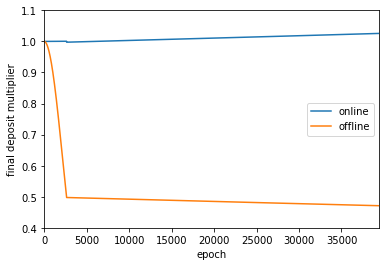

In [85]:
c = UnitEContract()
c.BASE_PENALTY_FACTOR = 2.0121e-7
c.initialize_epoch(0)
deposit = target_total_deposit/2
c.deposit(deposit)
c.deposit(deposit)

roi_online = []
roi_offline = []

for i in range(1, int(block_yr/50)):
    c.initialize_epoch(i)
    if i < 4:
        c.vote(0, i-1, i)
    elif i < 2630:
        c.vote(0, 3, i)
    else:
        c.vote(0, i-1, i)
    
    roi_online.append(c.deposit_size(0) / deposit * 1e8)
    roi_offline.append(c.deposit_size(1) / deposit * 1e8)
    
plt.plot(range(len(roi_online)), roi_online, label="online")
plt.plot(range(len(roi_offline)), roi_offline, label="offline")
plt.xlabel('epoch')
plt.ylabel('final deposit multiplier')
plt.legend(loc='center right')
plt.axis([0, len(roi_online), 0.4, 1.1])
plt.show()
print(roi_online[len(roi_online)-1]-1)
print(f'voters yearly yield: {"{:.2%}".format(roi_online[len(roi_online)-1]-1)}')
print(f'non-voters yearly yield: {"{:.2%}".format(roi_offline[len(roi_offline)-1]-1)}')

In a less extreme scenario if only 30% of the stake is owned by non-voting validators, then finalization can be achieved and both parties (voters and non-voters) face milder consequences.

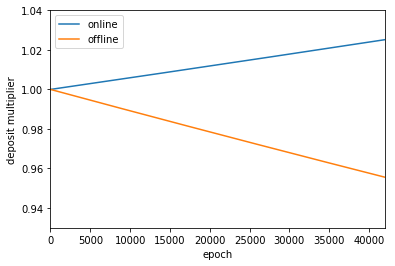

voters yearly yield: 2.52%
non-voters yearly yield: -4.45%


In [87]:
c = UnitEContract()

c.initialize_epoch(0)
c.deposit(target_total_deposit * 0.7)
c.deposit(target_total_deposit * 0.3)

roi_online = []
roi_offline = []

for i in range(1, time_span):
    c.initialize_epoch(i)
    c.vote(0, i - 1, i)
    roi_online.append(c.deposit_size(0) / (target_total_deposit * 0.7) * 1e8)
    roi_offline.append(c.deposit_size(1) / (target_total_deposit * 0.3) * 1e8)
    
plt.plot(range(len(roi_online)), roi_online, label="online")
plt.plot(range(len(roi_offline)), roi_offline, label="offline")
plt.xlabel('epoch')
plt.ylabel('deposit multiplier')
plt.legend(loc='upper left')
plt.axis([0, len(roi_online), 0.93, 1.04])
plt.show()

print(f'voters yearly yield: {"{:.2%}".format(roi_online[len(roi_online)-1]-1)}')
print(f'non-voters yearly yield: {"{:.2%}".format(roi_offline[len(roi_offline)-1]-1)}')

#### Validators costs
In orded to make sure that running a validator node is a feasable business we need to estimate the cost of running such nodes with commercial grade equipment. Amazon provides competive prices for renting hardware, using their cost estimator [4] and what we think the minimum set up that has enough security guarantees, we end up with the following list:  

- 1 x Linux on a1.2xlarge  
- 5 x Linux on t3.2xlarge  
- 1 x EBS backup 2TB  
- 800 GB in per month  
- 800 GB out per month  
- Cloud HSM  

Reserving those instance for 5 years and splitting the costs over such periods, including the monthly rent for some of those services we arrive to a sum very close to 27,000$.

Given the above estimation follows a table with the minimum amount of stake that is required to break even, netting out the inflation, at different coin evaluations.

In [163]:
validator_cost = 27_000

print(f'market value \t $ investment \t fraction of supply \t fraction of TD')
for i in [0.02, 0.05, 0.1, 0.5, 1]:
    inv = (int)(validator_cost/(yr_yield_over_infl * i))
    inv_s = "{:,}".format(inv)
    frac_supply = "{:.2%}".format(inv*UNIT/i/actual_supply)
    frac_TD = "{:.2%}".format(inv*UNIT/i/target_total_deposit)
    print(f'{i} \t\t {inv_s}$ \t {frac_supply}  \t\t {frac_TD}')    

market value 	 $ investment 	 fraction of supply 	 fraction of TD
0.02 		 40,854,162$ 	 75.15%  		 756.56%
0.05 		 16,341,664$ 	 12.02%  		 121.05%
0.1 		 8,170,832$ 	 3.01%  		 30.26%
0.5 		 1,634,166$ 	 0.12%  		 1.21%
1 		 817,083$ 	 0.03%  		 0.30%


## Unit-e Proposers economic model

Since we want to incentivize vote inclusion and prevent censorhip of validators from purely economic opportunities, and to do so we use the sigmoid function $atan(x)$ to weigth the total reward given to proposers from the coinbase.
Furthermore only 10% of the total potential block reward is given immediately to the poposer, while the remaining portion will be awarded at the checkpoint of the next epoch that determines a new dynasty.  
In this way we basically award only 10% of the possible reward to proposers immediately and we keep the rest as strong incentive to include as many votes as possible and help finalization.  
As for the validator fund any inefficiency due to non-optimal finalization will cause the exceeding funds to be burned.

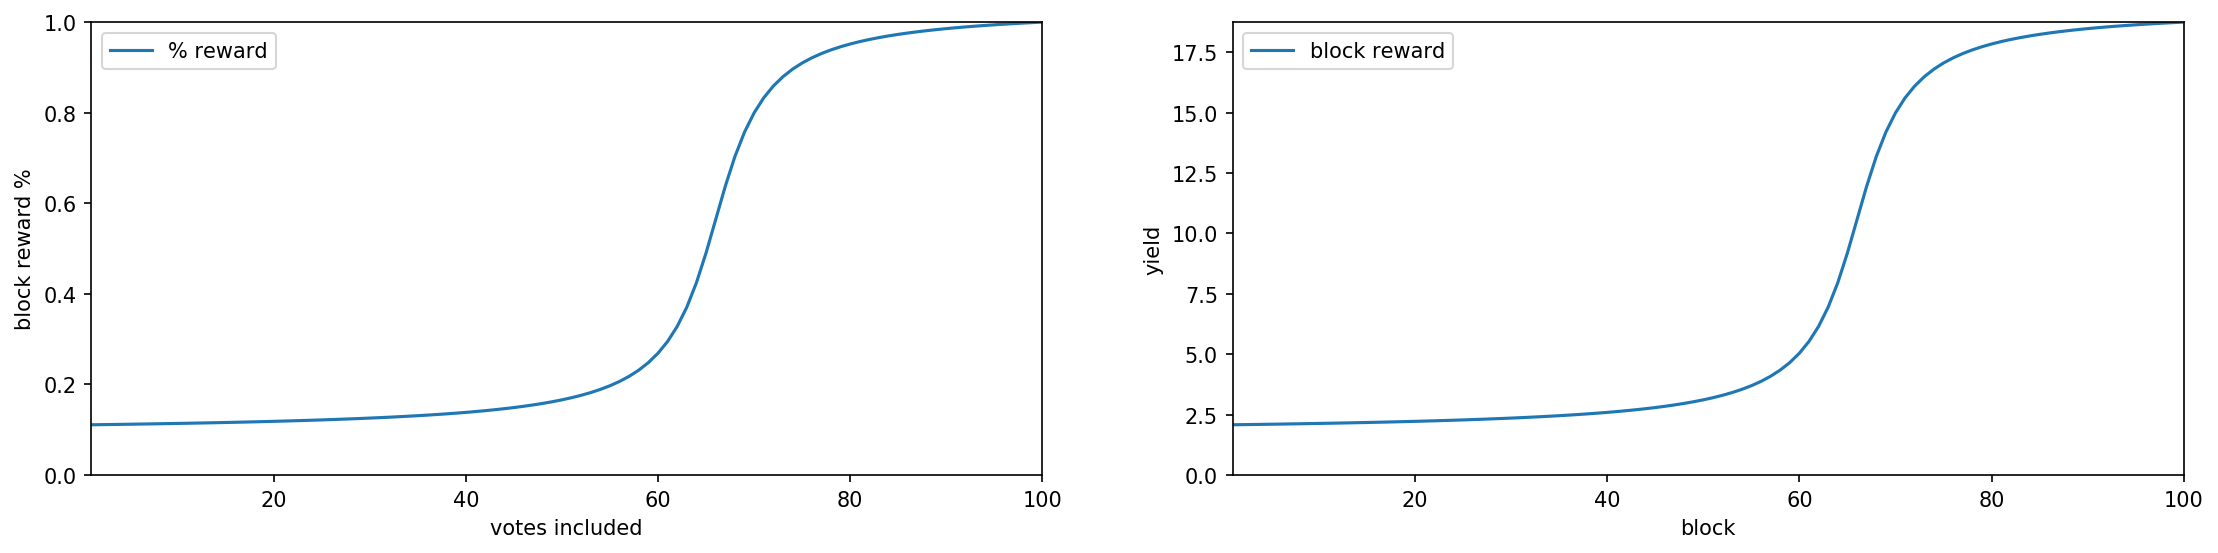

% votes included 	 % block reward 	 block reward
0% 			 11.08%   		 2.08
5% 			 11.23%   		 2.10
10% 			 11.40%   		 2.14
15% 			 11.61%   		 2.18
20% 			 11.86%   		 2.22
25% 			 12.18%   		 2.28
30% 			 12.58%   		 2.36
35% 			 13.11%   		 2.46
40% 			 13.84%   		 2.60
45% 			 14.91%   		 2.80
50% 			 16.61%   		 3.11
55% 			 19.73%   		 3.70
60% 			 26.90%   		 5.04
65% 			 49.04%   		 9.19
66% 			 56.39%   		 10.57
67% 			 63.74%   		 11.95
70% 			 79.95%   		 14.99
75% 			 90.96%   		 17.06
80% 			 95.16%   		 17.84
85% 			 97.29%   		 18.24
90% 			 98.56%   		 18.48
95% 			 99.40%   		 18.64
100% 			 100.00%   		 18.75


In [194]:
def proposer_reward_fraction(vote_fraction):
    vote_fraction = ((vote_fraction-0.16) * 25) - 12.5
    return 0.1 + ((np.arctan(vote_fraction)+1.5462)/3)*0.9

reward_fr = []
reward = []
for i in range(0,101):
    reward_fr.append(proposer_reward_fraction(i*0.01))
    reward.append(reward_fr[i]*adj_blk_rw(1)*0.5/UNIT)

plt.figure(figsize=(18, 4), dpi=150, facecolor='w', edgecolor='k')
plt.subplot(1,2,1)
plt.plot(range(len(reward_fr)), reward_fr, label="% reward")
plt.xlabel('votes included')
plt.ylabel('block reward %')
plt.axis([1, 100, 0, 1])
plt.legend(loc='upper left')

plt.subplot(1,2,2)
plt.plot(range(len(reward)), reward, label="block reward")
plt.xlabel('block')
plt.ylabel('yield')
plt.legend(loc='upper left')
plt.axis([1, 100, 0, 37.5/2])

plt.show()

print(f'% votes included \t % block reward \t block reward')
for i in range(0, len(reward_fr)):
    if i % 5 == 0 or i in [65,66,67]:
        print(f'{i}% \t\t\t {"{:.2%}  ".format(reward_fr[i])} \t\t {"{:.2f}".format(reward[i])}')


### Attacking the protocol (TODO)
In this section we will analyze different possible strategies to damage the participant in the protocol through the reward structure. In particular if there is any strategy that leads with a small loss from the attacker to disproportionate losses among one or other actors.


#### Validator vs. validator griefing
A validator could decide not to vote, to cause the overall reward factor to be shrinked, causing an inferior yield to all the other validators.


#### Proposer vs. validator griefing
A proposer could decide not to include votes from one or multiple validators hence shrinking their yield and in the worse case preventing finalization.

#### Validator vs. proposer griefing
A validator could decide not to vote for the sole purpose of damaging the return of the proposers, in fact diminishing circulating supply and lowering the inflation.

## References

[1] Danny R., Chih-Cheng L., EIP-1011: Hybrid Casper FFG, URL https://github.com/ethereum/EIPs/blob/master/EIPS/eip-1011.md  
[2] Buterin V., Griffith V., Casper the Friendly Finality Gadget, URL https://arxiv.org/abs/1710.09437v3  
[3] G. Fanti, L. Kogan, S. Oh, K. Ruan, P. Viswanath, G. Wang, Compounding of Wealth in Proof-of-Stake Cryptocurrencies, URL https://arxiv.org/abs/1809.07468  
[4] Amazon price estimator, URL http://calculator.s3.amazonaws.com/index.html